In [1]:
# import libraries
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix

In [2]:
# read data into dataframes
train_df = pd.read_csv(r'data\train.csv')

In [3]:
print("Columns = ",np.array2string(train_df.columns))
print("________________________________________________________________________________")
print("Dataframe size = ",train_df.shape)
print("________________________________________________________________________________")
print("Number of null entries")
print(train_df.isna().sum())
print("________________________________________________________________________________")
print("Statistics")
print(train_df.drop(columns=['PassengerId','Name']).describe().to_string())

Columns =  ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
________________________________________________________________________________
Dataframe size =  (891, 12)
________________________________________________________________________________
Number of null entries
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
________________________________________________________________________________
Statistics
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.0

#### Variable Notes 
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 

sibsp: The dataset defines family relations in this way


Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way


Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Data Preprocessing

In [4]:
#create a family size column, combining both sibsp and parch columns
train_df['Family Size'] = train_df['SibSp'] +train_df['Parch'] 

In [5]:
train_df['Ticket'].unique().shape

(681,)

In [6]:
df = pd.DataFrame(columns =train_df.columns)
for x in train_df['Ticket'].head(5):
    print("Ticket = {}\n {}\n".format(x,train_df['Family Size'].loc[train_df['Ticket']== x].to_string()))

Ticket = A/5 21171
 0    1

Ticket = PC 17599
 1    1

Ticket = STON/O2. 3101282
 2    0

Ticket = 113803
 3      1
137    1

Ticket = 373450
 4    0



The same ticket number indicate that the group were traveling together

In [7]:
# create an alone column for passengers that boarded the titanic alone
#ticket number only available for one passenger and family size is 0
test = train_df.set_index('Ticket')
test['Alone'] = np.nan
test.loc[(train_df.groupby(['Ticket']).count()['PassengerId'] ==1),'Alone'] = 1
test.loc[(test['Family Size'] > 0) & (test['Alone'] == 1), 'Alone'] = 0
test['Alone'] = test['Alone'].fillna(0)
train_df['Alone'] = train_df.PassengerId.map(test.set_index('PassengerId')['Alone'])
train_df.drop(columns=['Ticket'],inplace=True)

In [8]:
# fill the null age values with the mean age value
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family Size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,NaN,S,1,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C85,C,1,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,NaN,S,0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,C123,S,1,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,NaN,S,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,NaN,S,0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.0000,B42,S,0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,23.4500,NaN,S,3,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.0000,C148,C,0,1.0


In [9]:
train_df.loc[train_df['Embarked'].isna()== True] 
train_df['Embarked'].loc[train_df['Pclass']== 1].value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

In [10]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [11]:
#set passengerid as index
train_df.set_index('PassengerId',inplace=True)

## Data Visualization

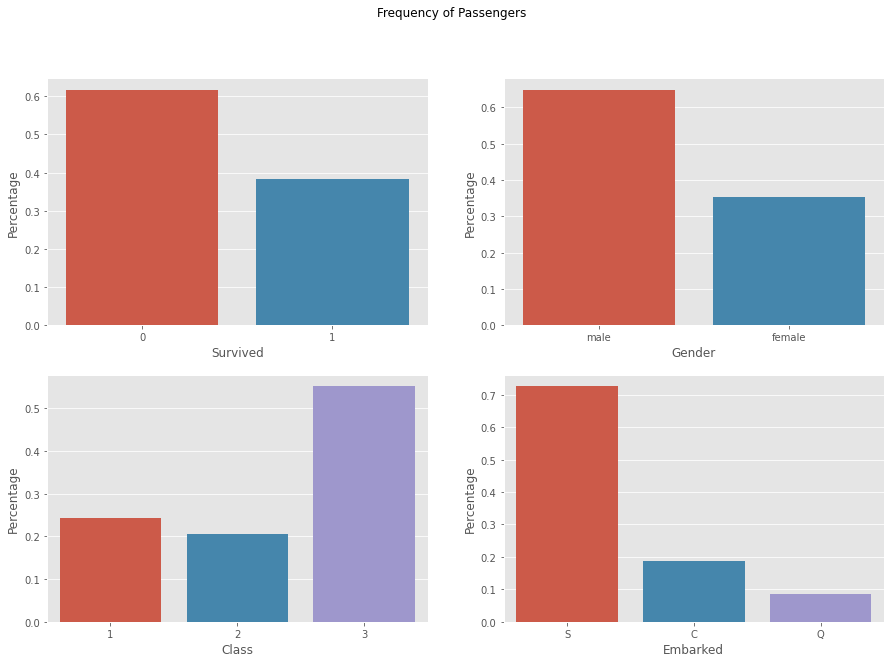

In [12]:
fig, ax =plt.subplots(2,2,figsize=(15,10))

sns.barplot(data=train_df,
            y=train_df['Survived'].value_counts(normalize = True).rename('Percentage'),
            x=train_df['Survived'].unique(), 
            ax=ax[0][0])
ax[0][0].set_xlabel('Survived')

sns.barplot(data=train_df,
            y=train_df['Sex'].value_counts(normalize = True).rename('Percentage'),
            x=train_df['Sex'].unique(),
            ax=ax[0][1])
ax[0][1].set_xlabel('Gender')

sns.barplot(data=train_df,
            y=train_df['Pclass'].value_counts(normalize = True).rename('Percentage'),
            x=train_df['Pclass'].unique(),
            ax=ax[1][0])
ax[1][0].set_xlabel('Class')

sns.barplot(data=train_df,
            y=train_df['Embarked'].value_counts(normalize = True).rename('Percentage'),
            x=train_df['Embarked'].unique(),
            ax=ax[1][1])
ax[1][1].set_xlabel('Embarked')

plt.suptitle("Frequency of Passengers")
plt.show()

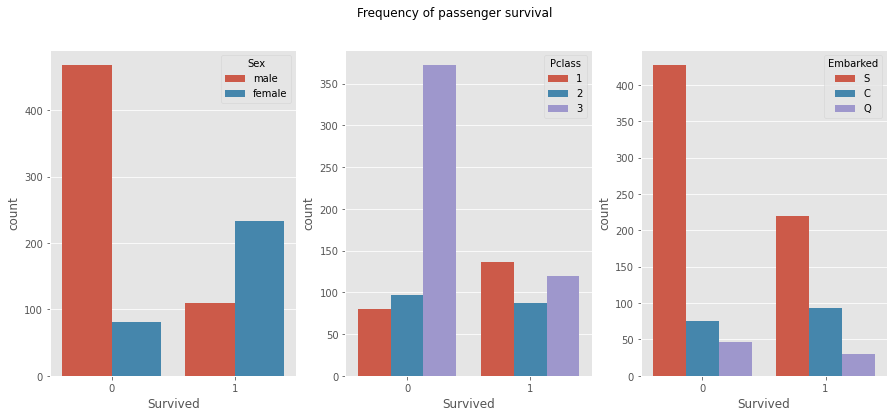

In [13]:
fig, ax =plt.subplots(1,3,figsize=(15,6))
sns.countplot(data=train_df,
              hue='Sex', 
              x='Survived',
              ax=ax[0])

sns.countplot(data=train_df,
              hue="Pclass", 
              x='Survived',
              ax=ax[1])

sns.countplot(data=train_df,
              hue='Embarked', 
              x='Survived',
              ax=ax[2])
plt.suptitle("Frequency of passenger survival")
plt.show()

			Passenger Survival based on class and embarked port


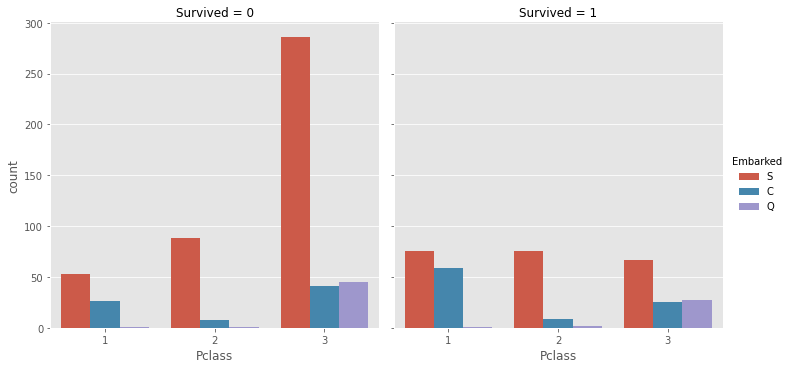

			Passenger Survival based on Gender and alone or not


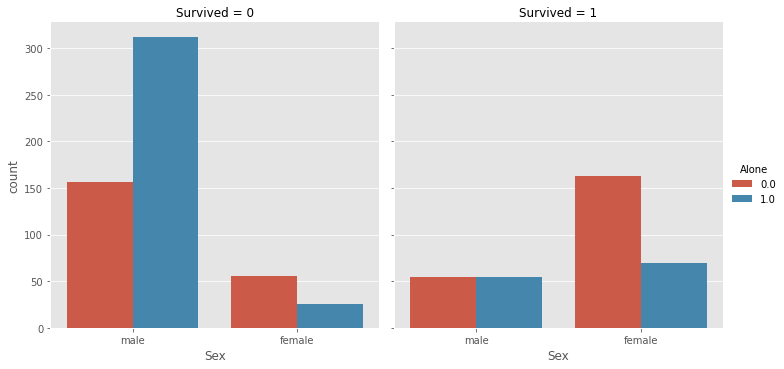

In [14]:
print("\t\t\t\033[1mPassenger Survival based on class and embarked port\033[0m")
sns.catplot(data=train_df,
            hue='Embarked', 
            x='Pclass',
            col='Survived',
            kind='count')
plt.show()
print("\t\t\t\033[1mPassenger Survival based on Gender and alone or not\033[0m")
sns.catplot(data=train_df,
            hue='Alone', 
            x='Sex', 
            col='Survived',
            kind='count')
plt.show()

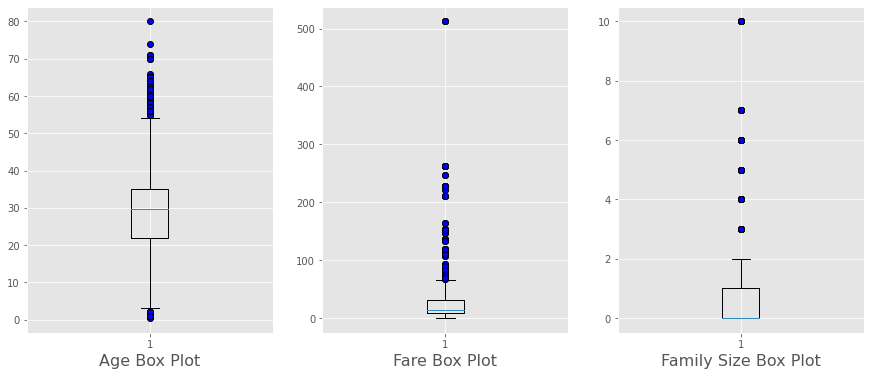

In [15]:
fig, ax =plt.subplots(1,3,figsize=(15,6))
ax[0].boxplot(train_df['Age'], 
              flierprops=dict(markerfacecolor='b', 
                              marker='o'), 
              showfliers=True, 
              vert=True)
ax[0].set_xlabel('Age Box Plot', size=16)


ax[1].boxplot(train_df['Fare'], 
              flierprops=dict(markerfacecolor='b', 
                              marker='o'), 
              showfliers=True, 
              vert=True)
ax[1].set_xlabel('Fare Box Plot', size=16)

ax[2].boxplot(train_df['Family Size'], 
              flierprops=dict(markerfacecolor='b', 
                              marker='o'), 
              showfliers=True, 
              vert=True)
ax[2].set_xlabel('Family Size Box Plot', 
                 size=16)
plt.show()

- The data is imbalanced, the passengers who didn't survive are almost twice the number of passengers that survived
- From the data we can see that more male passengers didn't survive
- More class 3 passengers didn't survive compared to other classes
- Most passengers were around the age of 3 and 53, more condensend from early twenties to mid thirties
- Most passengers had a fairly low fare, with outliers having fare from 70s to 500s
- The average family size is zero and outliers start from more than 2, meaning that not alot of families                        were on board 
    

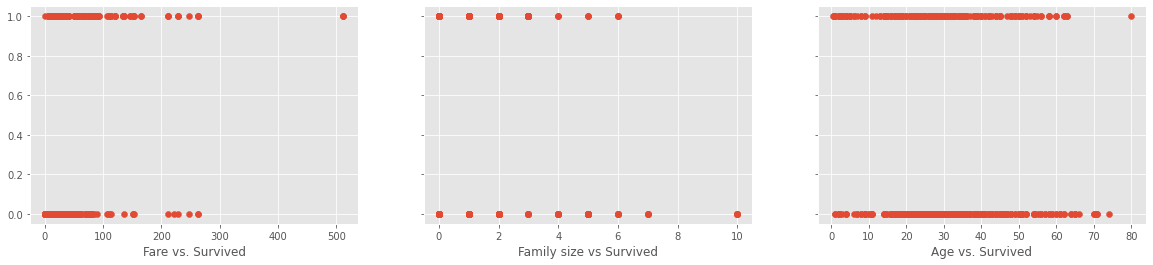

In [16]:
fig, ax = plt.subplots(1,3,figsize=(20,4),sharey=True)

ax[0].scatter(train_df['Fare'], 
              train_df['Survived'])
ax[0].set_xlabel('Fare vs. Survived')

ax[1].scatter(train_df['Family Size'], 
              train_df['Survived'])
ax[1].set_xlabel('Family size vs Survived')

ax[2].scatter(train_df['Age'], 
              train_df['Survived'])
ax[2].set_xlabel('Age vs. Survived')

plt.show()

- Fare, family size and age are normally distributed features

In [17]:
# draw the correlation matrix
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Family Size,Alone
Survived,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,0.016639,-0.241717
Pclass,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,0.065997,0.218834
Age,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,-0.248512,0.163989
SibSp,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,0.890712,-0.492459
Parch,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,0.783111,-0.491554
Fare,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,0.217138,-0.404686
Family Size,0.016639,0.065997,-0.248512,0.890712,0.783111,0.217138,1.000000,-0.582151
Alone,-0.241717,0.218834,0.163989,-0.492459,-0.491554,-0.404686,-0.582151,1.000000


In [18]:
# drop highly correlated features with name and cabin
train_df.drop(
    columns=['SibSp','Parch','Name','Cabin'],
    inplace=True)

In [19]:
# code categorical data
train_df = pd.get_dummies(train_df)

In [20]:
train_df

,Survived,Pclass,Age,Fare,Family Size,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.000000,7.2500,1,0.0,0,1,0,0,1
2,1,1,38.000000,71.2833,1,0.0,1,0,1,0,0
3,1,3,26.000000,7.9250,0,1.0,1,0,0,0,1
4,1,1,35.000000,53.1000,1,0.0,1,0,0,0,1
5,0,3,35.000000,8.0500,0,1.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.000000,13.0000,0,1.0,0,1,0,0,1
888,1,1,19.000000,30.0000,0,1.0,1,0,0,0,1
889,0,3,29.699118,23.4500,3,0.0,1,0,0,0,1


## Classification Model

In [21]:
# preprocess data for entering the model
def preprocess_data(df):
    # create the family size column
    df['Family Size'] = df['SibSp'] + df['Parch'] 
    # create an alone column 
    df.set_index('Ticket',inplace=True)
    df['Alone'] = np.nan
    df.loc[(df.groupby(['Ticket']).count()['PassengerId']) ==True,'Alone'] = 1
    df.loc[(df['Family Size'] > 0) & (df['Alone'] == 1), 'Alone'] = 0
    df['Alone'] = df['Alone'].fillna(0)
    df.reset_index(inplace=True)
    # drop the columns
    df.drop(
    columns=['SibSp','Parch','Name','Cabin','Ticket'],
    inplace=True)
    df = df.fillna(test_df.mean())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].fillna(df['Embarked'].mode()))
    
    # code categorical columns
    df.set_index("PassengerId", inplace = True)
    df = pd.get_dummies(df)
    df_scale = preprocessing.StandardScaler().fit_transform(df)
    return df_scale


In [22]:
# scale data before passing it into the mode
X_norm = preprocessing.StandardScaler().fit_transform(train_df.drop(columns=['Survived']))
X_norm
Y = train_df['Survived']

In [23]:
# split data to measure accuracy of logistic regression and ridge regression and choose the optimal model
x_train, x_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=0)

In [24]:
# class weight is balanced as the number of passengers that didn't survive the titanic are higher making the label imbalanced
lg_model = LogisticRegression(class_weight='balanced',random_state=42)
lg_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [25]:
lg_pred = lg_model.predict(x_test)

In [26]:
ridge_model = RidgeClassifier(class_weight='balanced',random_state=42)
ridge_model.fit(x_train,y_train)

RidgeClassifier(class_weight='balanced', random_state=42)

In [27]:
pred_ridge = ridge_model.predict(x_test)

In [28]:
print("Classification report for the Logistic Regression model\n\n",classification_report(pred_ridge, y_test))
print("Classification report for the Ridge Regression model\n\n",classification_report(lg_pred, y_test))

Classification report for the Logistic Regression model

               precision    recall  f1-score   support

           0       0.80      0.87      0.83       101
           1       0.81      0.72      0.76        78

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.80      0.80       179

Classification report for the Ridge Regression model

               precision    recall  f1-score   support

           0       0.79      0.88      0.83        99
           1       0.83      0.71      0.77        80

    accuracy                           0.80       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.80      0.80       179



Logistic regression and ridge regression are very close however, given the data I think ridge regression would be better

## Predicting the test file

In [29]:
test_df = pd.read_csv(r'data/test.csv')

In [30]:
test_df2 = preprocess_data(test_df)

In [31]:
test_df.set_index("PassengerId",inplace=True)

In [35]:
final_pred = ridge_model.predict(test_df2)

In [36]:
pred_df = pd.DataFrame(final_pred, columns = ['Survived'])
pred_df.set_index(test_df.index, inplace = True)
pred_df.head(10)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [37]:
pred_df.to_csv(r'data/predictions.csv', index=True)